# Creating a simple neural network

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [15]:


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

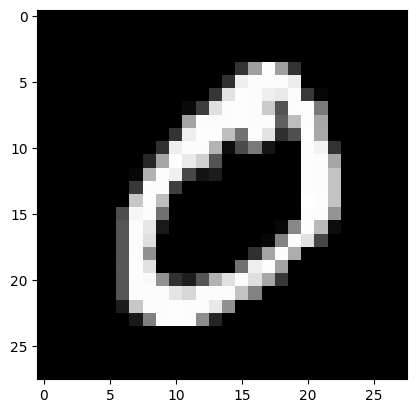

In [17]:
img = train_dataset[1][0]
plt.imshow(img.squeeze(), cmap="gray")

In [2]:
import torch.nn as nn


In [3]:
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten input if needed (e.g., for MNIST 28x28 images)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x



In [4]:
myfirstnn = SimpleNN()